In [576]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.special import logsumexp
import tqdm

In [577]:
loc = np.array([1, 10, 100])
scale = np.array([1, 1, 1])
a_trunc = np.array([0, 0 , 0])
b_trunc = np.array([1.1, 11, 98])

a, b = (a_trunc - loc) / scale, (b_trunc - loc) / scale

truncnorm.rvs(a, b, loc=loc, scale=scale)

array([ 0.25431594,  9.3291677 , 97.68964522])

In [578]:
n_avg = 100
x = np.array([1,0,100])
lenx = len(x)
acca = np.array([[1,2,3],[4,5,6]])
logsumexp( np.sum( norm.logpdf( acca , loc = x, scale = sn), axis = 1 ) )

-4437.756815599614

In [579]:
norm.logpdf( acca , loc = x, scale = sn)

array([[-9.18938533e-01, -2.91893853e+00, -4.70541894e+03],
       [-5.41893853e+00, -1.34189385e+01, -4.41891894e+03]])

In [580]:
np.sum( norm.logpdf( acca , loc = x, scale = sn), axis = 1 )

array([-4709.2568156, -4437.7568156])

In [581]:
np.exp(np.sum( norm.logpdf( acca , loc = x, scale = sn), axis = 1 ))

array([0., 0.])

In [582]:
np.sum(np.exp(np.sum( norm.logpdf( acca , loc = x, scale = sn), axis = 1 )))

0.0

In [583]:
np.log(np.sum(np.exp(np.sum( norm.logpdf( acca , loc = x, scale = sn), axis = 1 ))))

C:\Users\marco\AppData\Local\Temp\ipykernel_15748\2460948977.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(np.sum(np.exp(np.sum( norm.logpdf( acca , loc = x, scale = sn), axis = 1 ))))


-inf

In [584]:
pars = np.array([0.5, 1, 100])
size = (10,3)
#h(pars, size)[0]
x = np.array([1,0,100])
sn = 10
print(h(pars, (10,3)))
acca = np.ones((10,3))
print(acca)
np.mean( np.exp( np.sum( norm.logpdf(acca , loc = x, scale = sn), axis = 1 )  ) )

n_avg = 10
x = np.array([1,0,100])
lenx = len(x)
logsumexp( np.sum( norm.logpdf( h(pars, (n_avg,lenx)) , loc = x, scale = sn), axis = 1 ) )

[[ 3.51183088e+01  4.08255820e+01  1.95919876e+01]
 [ 1.20876951e-01 -8.54147269e-01 -7.07609555e+01]
 [ 3.87056657e+01 -1.11865437e+02 -4.41651423e+01]
 [-4.73372189e+01 -1.28339560e+00  9.22743454e-02]
 [-2.79705534e+01 -1.95872394e+02 -3.62244602e-01]
 [ 1.18082346e+01  7.63794341e-01  1.82226648e+02]
 [ 6.24373074e-01 -8.21863465e+01  2.08682810e+02]
 [ 5.06499307e-01 -1.21844008e+00  1.99457325e-01]
 [ 3.45866256e+01 -3.57166780e-01  3.04422481e+01]
 [-1.04757401e+00  2.97132322e+01 -6.53279443e+01]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


-51.961873289666286

In [585]:
def h(pars, size):
    return norm.rvs(loc = 0, scale = np.random.choice(pars[1:], p = [pars[0],1-pars[0]], size = size))

def sampling(n, x, sn, scale, n_avg):
    lenx = len(x)
    samples = []
    a_trunc = np.array([0, 0 , 0])
    b_trunc = np.array([1, 10, 10])
    pars = np.array([0.5, 0.5, 0.5])
    logl = logsumexp( np.sum( norm.logpdf( h(pars, (n_avg,lenx)) , loc = x, scale = sn), axis = 1 ) ) 
    plog = np.log(np.random.uniform(0,1,n))
    c = 0
    pb = tqdm.tqdm(range(n))
    medie = pars
    for i in pb:
        acp = i and c/i or 0
        if c > 2 : medie = np.mean( np.array( samples ), axis = 0 )
        pb.set_description("Acceptance rate %f, pars mean = %f, %f, %f,  logl = %f" % (acp, medie[0], medie[1], medie[2], logl ) )
        a, b = (a_trunc - pars) / scale, (b_trunc - pars) / scale
        pars_pr = truncnorm.rvs(a, b, loc=pars, scale=scale)
        #print(pars_pr)
        logl_pr = logsumexp( np.sum( norm.logpdf( h(pars_pr, (n_avg,lenx)) , loc = x, scale = sn), axis = 1 ) )
        #print(logl_pr, '\n')
        if plog[i] <= (logl_pr - logl):
            logl= logl_pr
            pars = pars_pr
            #print(pars)
            c+=1
        samples.append(pars)
    return np.array(samples)

In [586]:
n = int(1e4)

sn = 1
vn = sn**2
pars = np.array([0.5, 0.05, 0.15])


s = h(pars, (1,n)) + np.random.normal(0, sn, n)
#print(s)

In [587]:
scale = pars * 0.5
n_avg = int(1e4)

n_met = int(1e4)

samples = sampling(n_met, s, sn, scale, n_avg)

Acceptance rate 0.139831, pars mean = 0.155497, 0.249682, 0.087818,  logl = -14099.694125:   2%|▏         | 236/10000 [23:24<16:08:43,  5.95s/it]


KeyboardInterrupt: 

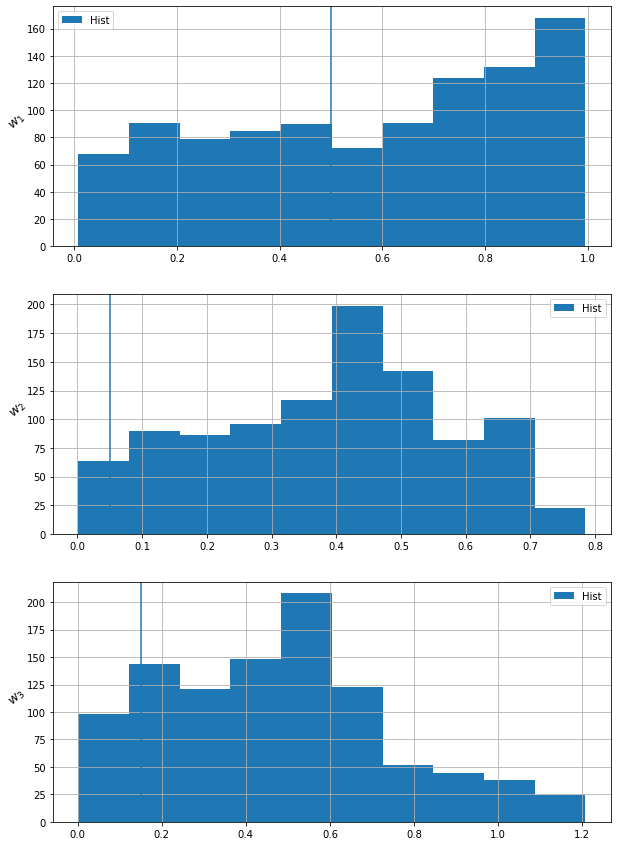

In [ ]:
n_pars = 3
fig, axs = plt.subplots( n_pars, figsize = [10,5*n_pars] )
w1 = samples
for i in range(n_pars):
    axs[i].hist(np.transpose(w1)[i], label = 'Hist')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    axs[i].grid()
    axs[i].legend()
    axs[i].axvline(x=pars[i])
    #axs[i].set_ylim([0,100])
#axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
#plt.savefig('Alpha'+str(alpha[0])+'_second.png')
plt.show()
plt.close()

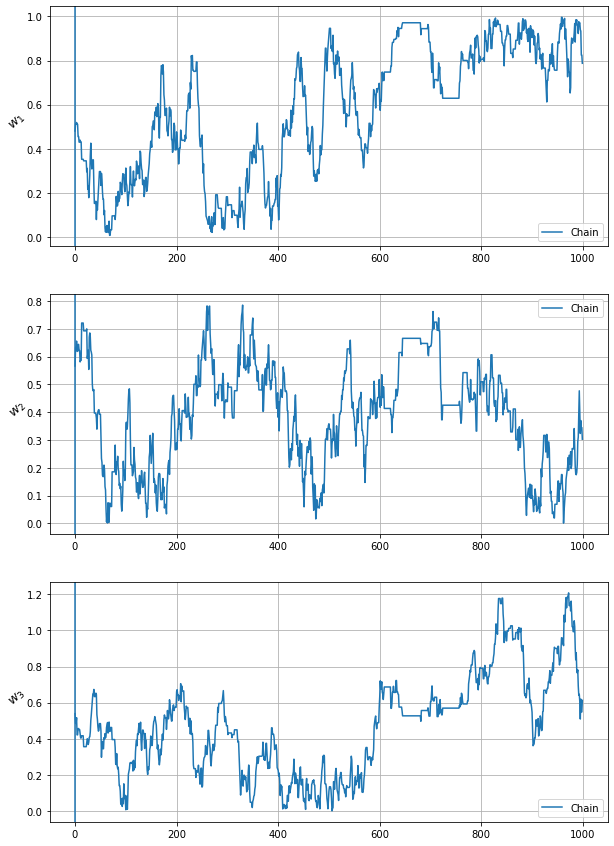

In [ ]:
n_pars = 3
fig, axs = plt.subplots( n_pars, figsize = [10,5*n_pars] )
w1 = samples
x = np.arange(n_met)
for i in range(n_pars):
    axs[i].plot(x, np.transpose(w1)[i], label = 'Chain')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    axs[i].grid()
    axs[i].legend()
    axs[i].axvline(x=pars[i])
    #axs[i].set_ylim([0,100])
#axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
#plt.savefig('Alpha'+str(alpha[0])+'_second.png')
plt.show()
plt.close()

In [ ]:
strain = h(n, p1, p2, s1, s2)
f = effe(s,strain,sn)
est = np.mean(f)
print(est)

TypeError: h() takes 2 positional arguments but 5 were given

In [ ]:
beta = 0.5
hg_rvs = hg(n, s, p1, p2, s1, s2, beta, vn)
f_div_g = effe_div_gi(s, hg_rvs, beta, sn)
est = np.mean(f_div_g)
print(est)

0.987381477115054


In [ ]:
mu1 = 1
mu2 = 2
mus = np.array([mu1, mu2])
ss1 = 1
ss2 = 1
ss = np.array([ss1,ss2])
ch = np.random.randint(0,2,n)
mus[ch]

array([1, 2, 1, ..., 2, 1, 1])